<a href="https://colab.research.google.com/github/robonesky/oreilly/blob/main/RM%20Lab%20Notes%2012%20202301%20cohort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=df4d0b77651288aa8e892d660c504253fc3fb03a8269d6c3ee34812c93e3b30f
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

np.random.seed(42)

dow = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')

dow

[                                                   0                                                  1
 0  Historical logarithmic graph of the DJIA from ...  Historical logarithmic graph of the DJIA from ...
 1                                         Foundation  February 16, 1885; 138 years ago[1] May 26, 18...
 2                                           Operator                              S&P Dow Jones Indices
 3                                          Exchanges  .mw-parser-output .plainlist ol,.mw-parser-out...
 4                                     Trading symbol                                  ^DJI$INDU.DJIDJIA
 5                                       Constituents                                                 30
 6                                               Type                                          Large cap
 7                                         Market cap           US$10.9 trillion (as of May 31, 2023)[3]
 8                                   Weighting method  

In [3]:
# the components table is the 2nd table:

dow[1]

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,2.41%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,3.02%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,5.48%
3,Apple,NASDAQ,AAPL,Information technology,2015-03-19,NaN,2.84%
4,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,3.36%
5,Caterpillar,NYSE,CAT,Construction and Mining,1991-05-06,NaN,4.52%
6,Chevron,NYSE,CVX,Petroleum industry,2008-02-19,Also 1930-07-18 to 1999-11-01,3.50%
7,Cisco,NASDAQ,CSCO,Information technology,2009-06-08,NaN,0.96%
8,Coca-Cola,NYSE,KO,Drink industry,1987-03-12,Also 1932-05-26 to 1935-11-20,1.22%
9,Disney,NYSE,DIS,Broadcasting and entertainment,1991-05-06,NaN,1.89%


In [4]:
# Now get the list of stock symbols:
dow_stocks = list(dow[1]['Symbol'])
dow_company_name = list(dow[1]['Company'])
dow_stocks[:5]

['MMM', 'AXP', 'AMGN', 'AAPL', 'BA']

In [5]:
dow_company_name[:5]

['3M', 'American Express', 'Amgen', 'Apple', 'Boeing']

In [6]:
# If you wanted to download direct from yahoo finance:
######################################################

# Use comprehension to fetch data for multiple fields
dow_ohlc = {symbol: yf.download(symbol, start='2010-01-01', end='2022-05-31', auto_adjust=True, progress=False) for symbol in dow_stocks}

# Save dow_ohlc dict for future use
np.save('./dow_ohlc.npy', dow_ohlc)



In [7]:
# get the open close high low data:

ohlc = np.load('./dow_ohlc.npy', allow_pickle = True).item()
ohlc['MMM'].head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,55.903374,56.145584,55.620797,55.856277,3043700
2010-01-05,55.708252,55.997559,54.968163,55.506409,2847000
2010-01-06,56.434864,56.919284,56.185929,56.293575,5268500
2010-01-07,56.058101,56.354137,55.250738,56.333954,4470100
2010-01-08,56.307057,56.730923,56.044664,56.730923,3405800


In [8]:
for symbol in dow_stocks:
  high = ohlc[symbol]['High']
  low = ohlc[symbol]['Low']
  close = ohlc[symbol]['Close']

  # not entirely clear what 'atr' is - "Average true Range" it seems.  It's a volatility thing
  ohlc[symbol]['ATR'] = ta.atr(high, low, close)

In [9]:
ohlc['MMM'].head()

# We'll have to sort out these NaNs later

,Open,High,Low,Close,Volume,ATR
Date,,,,,,
2010-01-04,55.903374,56.145584,55.620797,55.856277,3043700,NaN
2010-01-05,55.708252,55.997559,54.968163,55.506409,2847000,NaN
2010-01-06,56.434864,56.919284,56.185929,56.293575,5268500,NaN
2010-01-07,56.058101,56.354137,55.250738,56.333954,4470100,NaN
2010-01-08,56.307057,56.730923,56.044664,56.730923,3405800,NaN


In [10]:
# returns

stock_price = pd.DataFrame(
    {symbol: ohlc[symbol]['Close']
    for symbol
    in dow_stocks}
)

stock_ret = stock_price.resample('W-FRI').last().pct_change()

stock_ret.head()



,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DOW,GS,HD,HON,IBM,INTC,JNJ,JPM,MCD,MRK,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-15,-0.011267,0.010489,-0.009160,-0.028541,-0.012662,0.003151,-0.003020,-0.010543,0.020670,-0.040150,NaN,-0.052206,-0.014148,0.012108,0.007108,-0.001440,0.005451,-0.022382,0.007115,0.046949,0.006523,-0.020237,0.006287,-0.074444,0.004736,0.032110,-0.036850,-0.009886,-0.010544,0.006563
2010-01-22,-0.022670,-0.089644,0.006222,-0.039722,-0.050148,-0.097638,-0.058563,-0.058607,-0.036418,-0.020261,NaN,-0.067126,-0.029752,-0.064508,-0.047655,-0.042789,-0.021066,-0.103480,0.017823,-0.015201,-0.061568,-0.021898,-0.001266,-0.059595,-0.009838,-0.017481,-0.007848,-0.039587,-0.016667,-0.013786
2010-01-29,-0.012150,-0.024099,0.033216,-0.028774,0.048987,-0.037051,-0.033114,-0.021768,0.000184,-0.014343,NaN,-0.035038,0.010462,-0.031093,-0.024781,-0.025615,-0.005380,-0.005618,-0.015144,-0.017752,-0.026934,0.012226,0.020561,-0.015339,0.048851,-0.004825,-0.030324,-0.008461,0.001667,0.009256
2010-02-05,-0.024227,0.005045,-0.013680,0.017703,-0.029724,-0.009380,-0.013034,0.054740,-0.021383,-0.000338,NaN,0.036579,-0.001071,-0.030280,0.009233,0.011637,-0.003500,-0.016436,0.015057,-0.037978,-0.005678,-0.032157,-0.004062,-0.023131,-0.007696,-0.013939,-0.023113,0.006461,-0.076005,0.000374


In [11]:
stock_ret.isnull().sum()

MMM       1
AXP       1
AMGN      1
AAPL      1
BA        1
CAT       1
CVX       1
CSCO      1
KO        1
DIS       1
DOW     481
GS        1
HD        1
HON       1
IBM       1
INTC      1
JNJ       1
JPM       1
MCD       1
MRK       1
MSFT      1
NKE       1
PG        1
CRM       1
TRV       1
UNH       1
VZ        1
V         1
WBA       1
WMT       1
dtype: int64

In [13]:
# What's going on with all these nulls, particularly for DOW?
# Looks like there's a problem with one particular date
# (and strangely, it's a different date for me than for Kannan!)

[stock_ret[x].index[stock_ret[x].apply(np.isnan)] for x in dow_stocks]

[DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08'], dtype='datetime64[ns]', name='Date', freq='W-FRI'),
 DatetimeIndex(['2010-01-08', '2010-01-15', '2010-01-22', '2010-01-29', '2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05', '2010-03-12',
              

<Axes: xlabel='Date'>

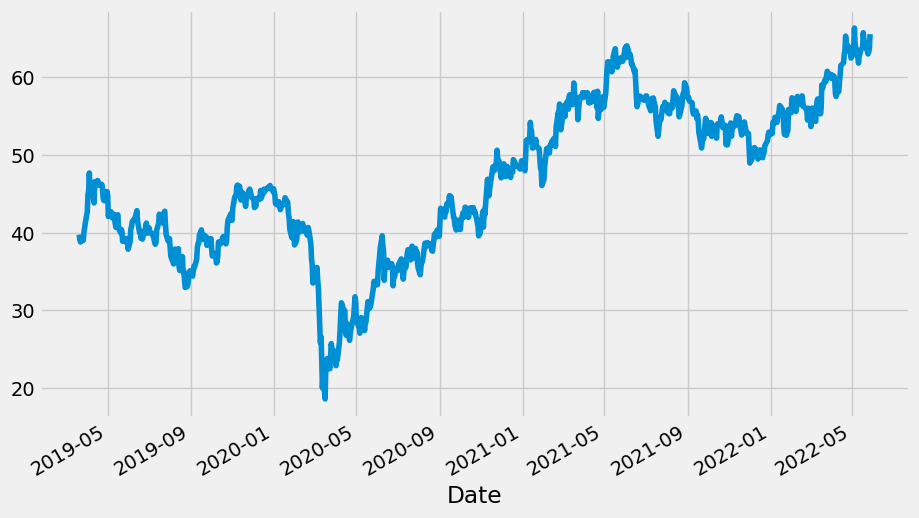

In [15]:
# That explains what's going on with the stocks with a single missing value, but what about
# DOW?

ohlc['DOW']['Close'].plot()

# We only have data since 2019, it seems, perhaps they changed the ticker or something

In [16]:
# Regardless.  Let's forward fill the other stocks, but drop DOW in its entirety

stock_ret.fillna(method='ffill', axis=0, inplace = True)
stock_ret.drop(['DOW'], axis = 1, inplace = True)
# stock_ret.dropna(inplace=True)

In [17]:
stock_ret.shape

(647, 29)

In [ ]:
np.isnan(stock_ret.any()).sum() # what's the diference between isnull().sum()?